In [1]:
import numpy as np
from tqdm import tqdm
import math
import random
import matplotlib.pyplot as plt
import statistics
from sklearn.preprocessing import normalize
import optim.optimizers as optimizers
import optim.projections as projections

In [2]:
#parameters

from scipy.io import loadmat
stocks = loadmat('data/data_490_1000.mat')

stocks_shape = stocks['A'].shape
number_of_stocks = stocks_shape[0]
number_of_trades = stocks_shape[1]
T = number_of_trades
D = math.sqrt(2)
G = 1
OGD_step = D / (G * math.sqrt(T))
OEG_step = OGD_step
num_of_simulations = 1

In [16]:
#calculating the loss

def loss(x, r_t):
    return -np.log(np.dot(x, r_t))

# revanue in time t
def revanue(x, r_t, wealth):
#     return np.dot(np.transpose(x), r_t) * wealth
    return np.dot(x, r_t) * wealth

# normalize vector

def normalize_func(x):
    sum_x = np.sum(x)
    x = x/sum_x
    return x

# gradient vector
def gradient(x, r_t):
#     #xTrt
#     xTrt = np.dot(np.transpose(x), r_t)
#     #scalar
#     scalar = -1 / xTrt
#     grad = scalar * r_t
#     return grad
    return -r_t * (1/np.dot(x, r_t))


#plot
def plot(final_OGD, final_EGD, final_ONS, final_rebalnce, final_fixed_stock, number_of_trades, num_of_simulations):
    if final_OGD is not 0:
        plt.plot(range(1, number_of_trades+1), final_OGD /  num_of_simulations, 'green')
    if final_EGD is not 0:
        plt.plot(range(1, number_of_trades+1), final_EGD /  num_of_simulations, 'red')
    if final_ONS is not 0:
        plt.plot(range(1, number_of_trades+1), final_ONS /  num_of_simulations, 'blue')
    if final_rebalnce is not 0:
        plt.plot(range(1, number_of_trades+1), final_rebalnce /  num_of_simulations, 'grey')
    if final_fixed_stock is not 0:
        plt.plot(range(1, number_of_trades+1), final_fixed_stock /  num_of_simulations, 'black')

    plt.legend(['OGD', 'EGD', 'ONS'
                , 'final_rebalnce', 'final_fixed_stock'], loc='best')
    plt.yscale('log')
    plt.xscale('log')
    plt.grid(True)
    plt.ylabel('Wealth')
    plt.xlabel('number_of_trades')
    plt.title('ORPS methods comparison')
    plt.savefig('ORPS methods comparison.png')
    plt.show()

In [4]:
#get r materix
def get_r_matrix(number_of_stocks, number_of_trades, stocks):
    r_matrix = np.zeros([number_of_stocks, number_of_trades-1])
    for stock in range(number_of_stocks):
        for trade in range(number_of_trades-1):
            r_matrix[stock][trade] = (stocks['A'][stock][trade + 1])/(stocks['A'][stock][trade])
    return r_matrix

#fixed_stock_solution
def best_fixed_stock_solution_func(number_of_trades, number_of_stocks, r_matrix):
    best_fixed_stock_solution = np.zeros(number_of_trades)
    for trade in range(number_of_trades-1):
        max = None
        for stock in range(number_of_stocks):
            if max == None or r_matrix[stock][trade] > max:
                best_fixed_stock_solution[trade] = stock
                max = r_matrix[stock][trade]
    return best_fixed_stock_solution

# best_rebalnce_solution
def best_rebalnce_solution(number_of_trades, r_matrix, number_of_stocks):
    best_fixed_stock_solution = best_fixed_stock_solution_func(number_of_trades, number_of_stocks, r_matrix)
    best_rebalnce_solution_wealth = np.zeros(number_of_trades)
    best_rebalnce_solution_wealth [0] = 1
    for trade in range(1,number_of_trades):
        best_rebalnce_solution_wealth[trade] = best_rebalnce_solution_wealth[trade-1] * r_matrix[int(best_fixed_stock_solution[trade-1])][trade-1]
    return best_rebalnce_solution_wealth

# best fixed stock
def fixed_stock_func(number_of_stocks, number_of_trades, r_matrix):
    all_stocks_wealth = np.zeros([number_of_stocks, number_of_trades])
    for stock in range(number_of_stocks):
        for trade in range(number_of_trades):
            if (trade == 0):
                all_stocks_wealth[stock][trade] = 1
                continue
            all_stocks_wealth[stock][trade] = all_stocks_wealth[stock][trade-1] * r_matrix[stock][trade-1]
    max = None
    index = None
    for stock in range(number_of_stocks):
        if ((max == None) or (all_stocks_wealth[stock][number_of_trades-1]>max)):
            max = all_stocks_wealth[stock][number_of_trades-1]
            index = stock    
    return all_stocks_wealth[index, :]

# temp reblance, not final

In [5]:
### temp reblance, not final

def total_gradient(x, r_matrix, number_of_trades):
    new_x = 0
    for i in range(number_of_trades-1):
        new_x += gradient(x,r_matrix[:,i])
    return new_x


def rebalnce_solution(x, number_of_trades, r_matrix, number_of_stocks,sim, step):
    for i in range(1, sim):
        grad = total_gradient(x, r_matrix, number_of_trades)
#         loss = total_loss(x, r_matrix)
        x = x - (step * grad)
        x = normalize_func(x)
    return x

def rebalnce_value(number_of_trades, x, r_matrix):
    scores_rebalnce = np.zeros(number_of_trades)
    scores_rebalnce[0] += 1
    for i in range(1, number_of_trades):
        scores_rebalnce[i] = scores_rebalnce[i-1] * (np.dot(np.transpose(x), r_matrix[:,i-1]))
    return scores_rebalnce
    

In [6]:
#Online_gradient_descent
def Online_gradient_descent(x, r_matrix, number_of_trades, step):
    scores_OGD = np.zeros(number_of_trades)
    scores_OGD[0] += 1
    for i in range(1, number_of_trades):
        x = x - step * gradient(x,r_matrix[:,i-1])
        x = normalize_func(x)
        scores_OGD[i] += revanue(x, r_matrix[:,i-1], scores_OGD[i-1])
    return scores_OGD

In [11]:
#denominator of the equation
def exp_stocks_t(x, rt, number_of_stocks, step):
    sum = 0
    for stock in range(number_of_stocks):
        sum += x[stock]* math.exp(-step*rt[stock])
    return sum

#Online Exponentiated Gradient
def Online_Exponentiated_Gradient(x, r_matrix, number_of_trades, number_of_stocks, step):
    scores_OEG = np.zeros(number_of_trades)
    scores_OEG[0] += 1
    for i in range(1, number_of_trades):
        denominator = exp_stocks_t(x, r_matrix[:,i-1], number_of_stocks, step)
        for stock in range(number_of_stocks): 
            x[stock] = (x[stock] * math.exp(-step * r_matrix[stock,i-1])) / denominator
        x = normalize_func(x)
        scores_OEG[i] += revanue(x, r_matrix[:,i-1], scores_OEG[i-1])
    return scores_OEG

In [29]:
def online_newton_step(number_of_trades, number_of_stocks, r_matrix, x):
    scores_ONS = np.zeros(number_of_trades)
    scores_ONS[0] += 1
    D = math.sqrt(2)
    G = np.max(np.linalg.norm(r_matrix, axis=0) / np.sum(r_matrix, axis=0))
    gamma = 0.5 *  (1 / (4 * G * D))
    epsilion = 1 / ((gamma ** 2) * (D**2))
    A = epsilion * np.eye(number_of_stocks)
    Ainv = (1 / epsilion) * np.eye(number_of_stocks)
    for trade in range(1, number_of_trades):
        r_t = r_matrix[ : , trade - 1]
        grad = gradient(x,r_t)
        grad_matrix = np.outer(grad, grad)
        A = A + grad_matrix
        Ainv = Ainv - (np.dot(Ainv, np.dot(grad_matrix, Ainv)) / (1 + np.dot(grad, np.dot(Ainv, grad))))
        yt = x - (1 / gamma) * np.dot(Ainv, grad)
        #need to implement MetricInducedSimplexProjection by myself
        proj = projections.MetricInducedSimplexProjection(A, eta_min=0.05)
        x = proj(yt)
        scores_ONS[trade] = revanue(x, r_t, scores_ONS[trade-1])
    return scores_ONS


In [26]:
# def _pt_generator(R, x):
#     d, T  = R.shape

#     # Hyperparameters
#     D = math.sqrt(2)
#     G = np.max(np.linalg.norm(R, axis=0) / np.sum(R, axis=0))
#     print(G)
#     eta = D / (G * math.sqrt(T))
#     scores_OGD = np.zeros(number_of_trades)
#     scores_OGD[0] += 1
#     for i in range(1, number_of_trades):
#         x = x - eta * gradient(x,r_matrix[:,i-1])
#         x = normalize_func(x)
#         scores_OGD[i] += revanue(x, r_matrix[:,i-1], scores_OGD[i-1])
#     return scores_OGD

100%|██████████| 1/1 [00:09<00:00,  9.50s/it]


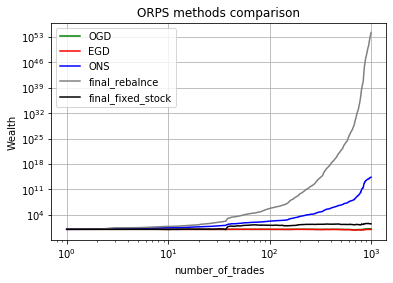

In [30]:
final_OGD = np.zeros(number_of_trades)
final_EGD = np.zeros(number_of_trades)
final_ONS = np.zeros(number_of_trades)
final_rebalnce = np.zeros(number_of_trades)
final_fixed_stock = np.zeros(number_of_trades)
for i in tqdm(range(num_of_simulations),total=num_of_simulations):
    x = np.zeros(number_of_stocks) + 1 
#     x += 1
    x = normalize_func(x)
    
#     G_ = np.max(np.linalg.norm(x, axis=1) / np.sum(x, axis=1))
    
    r_matrix = get_r_matrix(number_of_stocks, number_of_trades, stocks)
#     matan = _pt_generator(r_matrix, x)

    
    #try
#     sim = 1000
#     temp_x = rebalnce_solution(x, number_of_trades, r_matrix, number_of_stocks,sim, step)
#     rebalnce_3 = rebalnce_value(number_of_trades, temp_x, r_matrix)
#     print(rebalnce_3[999])
#     raise
    
    

    OGD = Online_gradient_descent(x, r_matrix, number_of_trades, OGD_step)
    EGD = Online_Exponentiated_Gradient(x, r_matrix, number_of_trades, number_of_stocks, OEG_step)
    ONS = online_newton_step(number_of_trades, number_of_stocks, r_matrix, x )
    rebalnce = best_rebalnce_solution(number_of_trades, r_matrix, number_of_stocks)
    fixed_stock = fixed_stock_func(number_of_stocks, number_of_trades, r_matrix)
    final_OGD += OGD
    final_EGD += EGD
    final_ONS += ONS
    final_rebalnce += rebalnce
    final_fixed_stock += fixed_stock
    
    
# raise
plot(final_OGD, final_EGD, final_ONS, final_rebalnce, final_fixed_stock, number_of_trades, num_of_simulations)
# plot(, final_EGD, final_ONS, final_rebalnce2, final_fixed_stock, number_of_trades, num_of_simulations)

In [34]:
ONS[0:100]

array([  1.        ,   1.03806339,   1.77814415,   1.82435558,
         1.8389603 ,   2.02366355,   2.3855645 ,   2.47898708,
         2.69069383,   2.6706304 ,   2.76655553,   2.72924386,
         2.96177061,   3.20421373,   3.31440106,   3.52499176,
         3.99762884,   4.02478023,   4.25048209,   4.46933082,
         5.24840326,   5.42913192,   5.47232417,   5.52673024,
         6.0832604 ,   6.38674957,   6.81610234,   7.53988905,
         7.76627417,   8.4245117 ,   8.76916749,  10.36918857,
        10.31718943,  10.7228869 ,  11.08254703,  11.79904686,
        12.3452547 ,  18.89464112,  24.85694027,  26.77333359,
        29.20571604,  33.85683609,  33.61331868,  32.69629408,
        33.71408324,  34.92020588,  36.81413334,  39.55543723,
        39.65416582,  41.36556114,  42.69676518,  47.40233944,
        50.09924465,  51.49968489,  58.7097675 ,  59.65906264,
        61.22098874,  61.05319001,  62.55173843,  63.43169104,
        67.00399573,  69.76380352,  73.16229391,  76.91

In [20]:
final_OGD[999]

1.4275043239603635